In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report


pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [2]:
data1 = pd.read_csv('../data/vector2.csv')

In [3]:
# # split the data in to train test and unseen

# sampled, unseen = train_test_split(data1, random_state=0, test_size=0.2, stratify=data1['review_rating'])
# train, test = train_test_split(sampled, random_state=0, test_size=0.2,stratify=sampled['review_rating'])
# train.shape, test.shape, unseen.shape

((125251, 12), (31313, 12), (39142, 12))

In [3]:
train = data1[data1['is_train']=='train']
test = data1[data1['is_train']=='test']
unseen = data1[data1['is_train']=='unseen']

# to_sav = pd.concat([train, test, unseen], axis=0)
# to_sav.to_csv('vector2.csv',index=False)

# create weighted tf idf weighted word2vec

In [4]:


sentences = [sentence.split() for sentence in train['lemmatized_clean_review_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
w2v_words = w2v_model.wv.index_to_key

# Define the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)


In [5]:
x_train_tfidf = vectorizer.fit_transform(train['lemmatized_clean_review_text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))

/Users/sarathyashu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
def get_weighted_w2v_tfidf(vectorizer, sentences):
    # TF-IDF weighted Word2Vec

    tfidf_feat = vectorizer.get_feature_names() # tfidf words/col-names

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0
    for sent in tqdm(sentences): # for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    print(len(tfidf_sent_vectors))
    return tfidf_sent_vectors

In [7]:
train['vector'] = get_weighted_w2v_tfidf(vectorizer, sentences)

100%|██████████████████████████████████| 125251/125251 [03:56<00:00, 529.00it/s]


125251


/var/folders/y4/_5b5gdl93l39cx1p6b825jlm0000gn/T/ipykernel_83638/240263936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vector'] = get_weighted_w2v_tfidf(vectorizer, sentences)


In [8]:
test_sentences = [sentence.split() for sentence in test['lemmatized_clean_review_text']]
unseen_sentences = [sentence.split() for sentence in unseen['lemmatized_clean_review_text']]

test['vector'] = get_weighted_w2v_tfidf(vectorizer, test_sentences)
unseen['vector'] = get_weighted_w2v_tfidf(vectorizer, unseen_sentences)

100%|████████████████████████████████████| 31313/31313 [01:06<00:00, 469.38it/s]


31313


/var/folders/y4/_5b5gdl93l39cx1p6b825jlm0000gn/T/ipykernel_83638/1702860722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['vector'] = get_weighted_w2v_tfidf(vectorizer, test_sentences)
100%|████████████████████████████████████| 39142/39142 [01:44<00:00, 374.36it/s]


39142


/var/folders/y4/_5b5gdl93l39cx1p6b825jlm0000gn/T/ipykernel_83638/1702860722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen['vector'] = get_weighted_w2v_tfidf(vectorizer, unseen_sentences)


# Model Selection using Kfold 

In [9]:
models = {'lgbm': LGBMClassifier(random_state=0, class_weight='balanced'),\
         'rf': RandomForestClassifier(random_state=0,class_weight='balanced'),\
         'lr': LogisticRegression(random_state=0,class_weight='balanced'),\
         'xgb': XGBClassifier(random_state=0)}

def evaluate_model(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return precision, recall, f1


skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# reset index
train = train.reset_index(drop=True)
# Create a new column to store the fold number
train['fold'] = np.nan

# Perform stratified k-fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(train, train['review_rating'])):
    # Update the fold number column for the current fold
    train.loc[test_index, 'fold'] = fold

In [ ]:
results_cn = []

for m in models.keys():

    # choose model
    model = models[m]
    
    # create the pipeline
    pipe = Pipeline([
                ('over',  RandomOverSampler(sampling_strategy={0:5000,1:5000,2:10000,3:30000,4:60500})),
                ('under', RandomUnderSampler(sampling_strategy= {0: 5000, 1: 5000, 2:10000, 3:20000,4:30000})),
                ('model',model)
            ])

    results = {}
    
    # iterate through folds
    for i in sorted(train['fold'].unique()):
        
        train['review_rating1'] = train['review_rating']-1
        
        val = train[train['fold']==i]
        n_train = train[train['fold']!=i]

        # assign x and y
        x_train = np.concatenate(n_train['vector'].apply(lambda x: x.reshape(1,-1)).values)
        x_val = np.concatenate(val['vector'].apply(lambda x: x.reshape(1,-1)).values)

        y_train = n_train['review_rating1'].values
        y_val = val['review_rating1'].values
        
        pipe.fit(x_train, y_train)
        pred = pipe.predict(x_val)
        # validate predictions
        precision, recall, f1 = evaluate_model(y_val, pred)
        results[f'fold{int(i)}'] = {'precision':precision,'recall':recall, 'f1':f1}
    
    # convert to dataframe
    results = pd.DataFrame(results)
    results['model'] = m
    
    # display results
    display(results)
    
    results_cn.append(results)
    


In [50]:
results_cn2 = pd.concat(results_cn)

In [70]:
kf_smy = pd.DataFrame(results_cn2.reset_index().set_index(['model','index'])[[f'fold{i}' for i in range(4)]].mean(axis=1))
kf_smy2 = pd.pivot_table(kf_smy,index='model', columns='index')
kf_smy2.columns = [f[1] for f in kf_smy2.columns]
kf_smy2

,f1,precision,recall
model,,,
lgbm,0.356471,0.336151,0.426658
lr,0.321154,0.313570,0.440663
rf,0.355295,0.478201,0.325681
xgb,0.380359,0.396003,0.369931


From the results we can observe that xgb gave best result

## Trying different oversampling techinques

In [110]:
# create the pipeline
pipe = Pipeline([
            ('over',  ADASYN(sampling_strategy='auto')),
            ('under', RandomUnderSampler(sampling_strategy= {0: 5000, 1: 5000, 2:10000, 3:20000,4:30000})),
            ('model', XGBClassifier(random_state=0))
        ])

results = {}

# iterate through folds
for i in sorted(train['fold'].unique()):

    train['review_rating1'] = train['review_rating']-1

    val = train[train['fold']==i]
    n_train = train[train['fold']!=i]

    # assign x and y
    x_train = np.concatenate(n_train['vector'].apply(lambda x: x.reshape(1,-1)).values)
    x_val = np.concatenate(val['vector'].apply(lambda x: x.reshape(1,-1)).values)
    y_train = n_train['review_rating1'].values
    y_val = val['review_rating1'].values

    pipe.fit(x_train, y_train)
    pred = pipe.predict(x_val)
    # validate predictions
    precision, recall, f1 = evaluate_model(y_val, pred)
    results[f'fold{int(i)}'] = {'precision':precision,'recall':recall, 'f1':f1}
  
pd.DataFrame(results)

,fold0,fold1,fold2,fold3,fold4
precision,0.379221,0.374306,0.375596,0.370807,0.374179
recall,0.371613,0.367227,0.379735,0.364986,0.368289
f1,0.372123,0.368819,0.373817,0.364762,0.368308


In [132]:
# create the pipeline
pipe = Pipeline([
            ('over',  SMOTE(sampling_strategy={0:5000,1:5000,2:10000,3:30000,4:60500})),
            ('under', RandomUnderSampler(sampling_strategy= {0: 5000, 1: 5000, 2:10000, 3:20000,4:30000})),
            ('model', XGBClassifier(random_state=0))
        ])

results = {}

# iterate through folds
for i in sorted(train['fold'].unique()):

    train['review_rating1'] = train['review_rating']-1

    val = train[train['fold']==i]
    n_train = train[train['fold']!=i]

    # assign x and y
    x_train = np.concatenate(n_train['vector'].apply(lambda x: x.reshape(1,-1)).values)
    x_val = np.concatenate(val['vector'].apply(lambda x: x.reshape(1,-1)).values)

    y_train = n_train['review_rating1'].values
    y_val = val['review_rating1'].values

    pipe.fit(x_train, y_train)
    pred = pipe.predict(x_val)
    # validate predictions
    precision, recall, f1 = evaluate_model(y_val, pred)
    results[f'fold{int(i)}'] = {'precision':precision,'recall':recall, 'f1':f1}
  
pd.DataFrame(results)

/Users/sarathyashu/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (60500) in class 4 will be larger than the number of samples in the majority class (class #4.0 -> 60342)
  warnings.warn(
/Users/sarathyashu/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (60500) in class 4 will be larger than the number of samples in the majority class (class #4.0 -> 60343)
  warnings.warn(
/Users/sarathyashu/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (60500) in class 4 will be larger than the number of samples in the majority class (class #4.0 -> 60343)
  warnings.warn(
/Users/sarathyashu/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (60500) in class 4 will be

,fold0,fold1,fold2,fold3,fold4
precision,0.390018,0.382394,0.396389,0.384144,0.391735
recall,0.391680,0.379913,0.400868,0.383830,0.387212
f1,0.389180,0.380316,0.397174,0.382617,0.388661


From the results we can observe smote improved the f1 score marginally on mean kfold f1 score

# Hyperparameter tunning of xgboost

In [133]:
# import packages for hyperparameters tuning


space={
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.uniform('reg_alpha', 50,180,),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 2500,50),
        'seed': 0
    }


In [179]:
x_train = np.concatenate(train['vector'].apply(lambda x: x.reshape(1,-1)).values)
x_test = np.concatenate(test['vector'].apply(lambda x: x.reshape(1,-1)).values)
x_unseen = np.concatenate(unseen['vector'].apply(lambda x: x.reshape(1,-1)).values)

y_train = (train['review_rating']-1).values
y_test = (test['review_rating']-1).values
y_unseen = (unseen['review_rating']-1).values



In [142]:
def objective(space):
    
    clf = xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    
    cw = Counter(y_train)
    pipe = Pipeline([
            ('over',  SMOTE(sampling_strategy={0:5000,1:5000,2:cw[2.0],3:cw[3.0],4:cw[4.0]})),
            ('under', RandomUnderSampler(sampling_strategy= {0: 5000, 1: 5000, 2:10000, 3:20000,4:30000})),
            ('model', clf)
        ])
    

    
    pipe.fit(x_train, y_train)    

    pred = pipe.predict(x_test)
    f1 = f1_score(y_test, pred, average='macro')
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [143]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)

SCORE:                                                                          
0.30798979637739954                                                             
SCORE:                                                                          
0.3235681530135893                                                              
SCORE:                                                                          
0.31994754814209597                                                             
SCORE:                                                                          
0.3220923318492607                                                              
SCORE:                                                                          
0.3266006752333704                                                              
SCORE:                                                                          
0.3244456402652352                                                              
SCORE:                      

In [144]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5683835009650924, 'gamma': 1.3696648183828148, 'max_depth': 7.0, 'min_child_weight': 5.0, 'n_estimators': 2200.0, 'reg_alpha': 91.57416479897962, 'reg_lambda': 0.3827218265196251}


# Final Model Performance

In [146]:
cw = Counter(y_train)
pipe = Pipeline([
        ('over',  SMOTE(sampling_strategy={0:5000,1:5000,2:cw[2.0],3:cw[3.0],4:cw[4.0]})),
        ('under', RandomUnderSampler(sampling_strategy= {0: 5000, 1: 5000, 2:10000, 3:20000,4:30000})),
        ('model', XGBClassifier(random_state=0))
    ])



pipe.fit(x_train, y_train)    

pred = pipe.predict(x_test)
unseen_pred = pipe.predict(x_unseen)
f1 = f1_score(y_test, pred, average='macro')

In [159]:
unseen_pred = pipe.predict(x_unseen)

39142

              precision    recall  f1-score   support

         0.0       0.27      0.37      0.31       322
         1.0       0.22      0.21      0.22       559
         2.0       0.34      0.30      0.32      2624
         3.0       0.43      0.40      0.41      8951
         4.0       0.73      0.77      0.75     18857

    accuracy                           0.61     31313
   macro avg       0.40      0.41      0.40     31313
weighted avg       0.60      0.61      0.61     31313



/Users/sarathyashu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


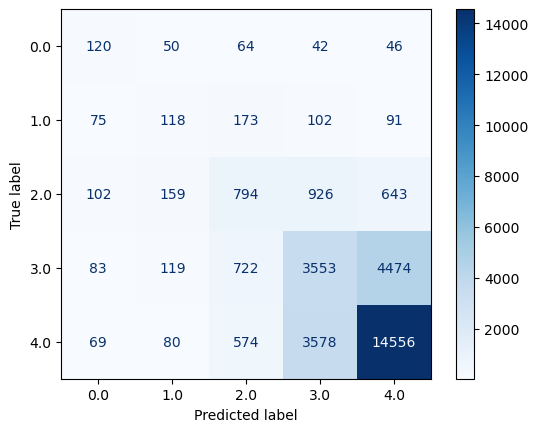

In [168]:
def validate_model(x_test, y_test, val_pred, model):
    print(classification_report(y_test,val_pred))
    plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    
validate_model(x_test, y_test, pred, pipe)



              precision    recall  f1-score   support

         0.0       0.26      0.36      0.30       403
         1.0       0.19      0.17      0.18       699
         2.0       0.34      0.31      0.33      3279
         3.0       0.43      0.39      0.41     11189
         4.0       0.74      0.78      0.76     23572

    accuracy                           0.61     39142
   macro avg       0.39      0.40      0.39     39142
weighted avg       0.60      0.61      0.60     39142



/Users/sarathyashu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


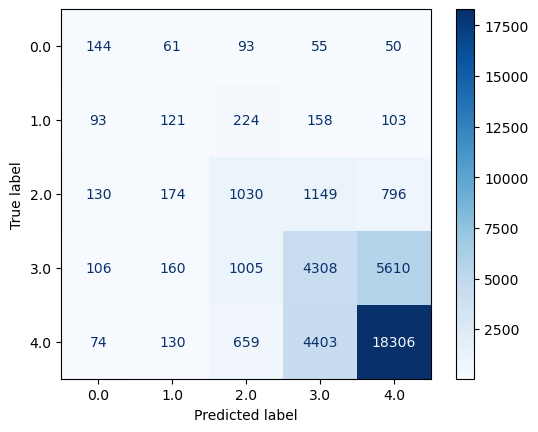

In [169]:
validate_model(x_unseen, y_unseen, unseen_pred, pipe)

In [173]:
train_pred = pipe.predict_proba(x_train)
test_pred = pipe.predict_proba(x_test)
unseen_pred = pipe.predict_proba(x_unseen)


In [181]:
train_pred_df = pd.DataFrame(train_pred, columns=[f'Predict_{f}' for f in range(1,6)])
test_pred_df = pd.DataFrame(test_pred, columns=[f'Predict_{f}' for f in range(1,6)])
unseen_pred_df = pd.DataFrame(unseen_pred, columns=[f'Predict_{f}' for f in range(1,6)])

In [184]:
train1 = pd.merge(train, train_pred_df, left_index=True, right_index=True)
test1 = pd.merge(test, test_pred_df, left_index=True, right_index=True)
unseen1 = pd.merge(unseen, unseen_pred_df, left_index=True, right_index=True)

In [185]:
to_sav = pd.concat([train1, test1, unseen1], axis=0)
to_sav.to_csv('vector2.csv',index=False)